In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from urllib.parse import urlparse
import psycopg2, os
from sklearn import preprocessing
from sqlalchemy import create_engine
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
postgresURL=urlparse(os.getenv('POSTGRES_URL'))
print(postgresURL)
connection = psycopg2.connect(host=postgresURL.hostname,
                        port=postgresURL.port,
                        user=postgresURL.username,
                        password=postgresURL.password,
                        sslmode='verify-full',
                        sslrootcert='/home/jovyan/postgres.pem',
                        database='ibmclouddb')

ParseResult(scheme='postgres', netloc='ibm_cloud_33e066c0_e55c_44a9_82eb_e4e2fbba067e:dca85a571fb4251d03f92ae4a30edea05dd36e9b5fb77303f51d9b06eb6f6b1b@dc2537b1-f539-4308-aec9-73a918fe9827.bkvfu0nd0m8k95k94ujg.databases.appdomain.cloud:32347', path='/ibmclouddb', params='', query='sslmode=disable', fragment='')


In [4]:
# Importing dataset - the generated simulator data
data = pd.read_sql_query('''SELECT measurement_time, temperature, target_temperature, ambiant_temperature, kilowatts, content_type, oxygen_level,nitrogen_level, carbon_dioxide_level, humidity_level, vent_1, vent_2, vent_3, time_door_open, defrost_cycle, maintenance_required  FROM reefer_telemetries;''',connection)
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
0,2019-09-16 23:41:28.424611,4.00000,4.0,18.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
1,2019-09-24 23:09:43.684149,6.68969,6.0,22.4282,2.927570,2.0,21.4124,-0.378142,4.03737,0.577301,True,True,True,1.619410,4.0,0.0
2,2019-09-24 23:14:43.684149,5.64922,6.0,18.5116,0.501211,2.0,19.6814,2.460760,4.24245,1.201170,True,True,True,0.170088,6.0,0.0
3,2019-09-24 23:19:43.684149,4.91638,6.0,20.8881,2.636550,2.0,20.7648,1.601000,2.75441,2.501910,True,True,True,2.273720,6.0,0.0
4,2019-09-24 23:24:43.684149,4.23752,6.0,20.1854,3.071450,2.0,21.1276,0.601678,2.54371,-0.589239,True,True,True,1.029000,3.0,0.0


In [5]:
# Clean bad rows
data=data.dropna()
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
1,2019-09-24 23:09:43.684149,6.68969,6.0,22.4282,2.927570,2.0,21.4124,-0.378142,4.03737,0.577301,True,True,True,1.619410,4.0,0.0
2,2019-09-24 23:14:43.684149,5.64922,6.0,18.5116,0.501211,2.0,19.6814,2.460760,4.24245,1.201170,True,True,True,0.170088,6.0,0.0
3,2019-09-24 23:19:43.684149,4.91638,6.0,20.8881,2.636550,2.0,20.7648,1.601000,2.75441,2.501910,True,True,True,2.273720,6.0,0.0
4,2019-09-24 23:24:43.684149,4.23752,6.0,20.1854,3.071450,2.0,21.1276,0.601678,2.54371,-0.589239,True,True,True,1.029000,3.0,0.0
5,2019-09-24 23:29:43.684149,6.47034,6.0,19.6761,0.878999,2.0,20.4821,0.052486,3.29618,1.073720,True,True,True,1.446830,5.0,0.0


In [6]:
# Convert dataset into array for the independent variables (features)
X = np.asarray(data[['temperature','target_temperature','ambiant_temperature','oxygen_level','carbon_dioxide_level','humidity_level','nitrogen_level','vent_1','vent_2','vent_3','kilowatts','content_type','time_door_open','defrost_cycle']])
X[0:5]

array([[6.68969, 6.0, 22.4282, 21.4124, 4.03737, 0.577301, -0.378142,
        True, True, True, 2.92757, 2.0, 1.61941, 4.0],
       [5.64922, 6.0, 18.5116, 19.6814, 4.24245, 1.20117, 2.46076, True,
        True, True, 0.501211, 2.0, 0.170088, 6.0],
       [4.91638, 6.0, 20.8881, 20.7648, 2.75441, 2.50191, 1.601, True,
        True, True, 2.63655, 2.0, 2.27372, 6.0],
       [4.23752, 6.0, 20.1854, 21.1276, 2.54371, -0.589239, 0.601678,
        True, True, True, 3.07145, 2.0, 1.029, 3.0],
       [6.47034, 6.0, 19.6761, 20.4821, 3.29618, 1.07372, 0.0524862,
        True, True, True, 0.878999, 2.0, 1.44683, 5.0]], dtype=object)

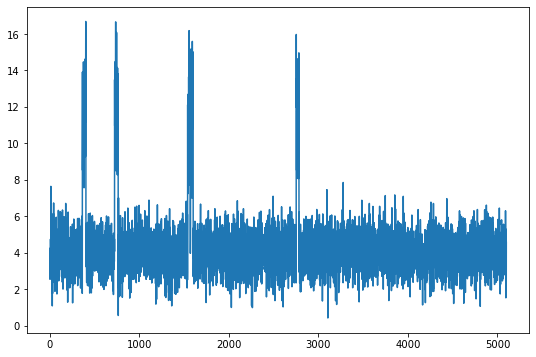

In [12]:
# Visualize the time series for co2 censor
fig,ax = plt.subplots(figsize=(9,6))
time_axe = np.arange(0,data['carbon_dioxide_level'].size,1)
ax.plot(time_axe,np.asarray(data[['carbon_dioxide_level']]))
plt.show()

In [13]:
# Convert dataset into array for the dependent (objective) variables
y = np.asarray(data['maintenance_required'])
y [0:5]

array([0., 0., 0., 0., 0.])

In [14]:
# Normalize/standardize (mean = 0 and standard deviation = 1) 
# your features before applying machine learning techniques.
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.70199118,  0.        ,  2.40217591,  0.34389415, -0.13698826,
        -0.80811182, -0.83483554,  0.        ,  0.        ,  0.        ,
         0.21582432,  0.        ,  0.60552678, -0.45881218],
       [-0.31623475,  0.        , -1.48431342, -0.68829309, -0.02111067,
        -0.79156555, -0.75949069,  0.        ,  0.        ,  0.        ,
        -2.21653967,  0.        , -0.84777491,  1.32876775],
       [-1.03340746,  0.        ,  0.87391614, -0.04226671, -0.86190688,
        -0.75706729, -0.78230884,  0.        ,  0.        ,  0.        ,
        -0.07591592,  0.        ,  1.26163344,  1.32876775],
       [-1.69775421,  0.        ,  0.17661847,  0.17406924, -0.98095997,
        -0.83905082, -0.80883098,  0.        ,  0.        ,  0.        ,
         0.36006041,  0.        ,  0.01349557, -1.35260215],
       [ 0.48733063,  0.        , -0.32876605, -0.21083941, -0.55578731,
        -0.79494578, -0.82340661,  0.        ,  0.        ,  0.        ,
        -1.83781668,  0.  

In [26]:
## randomly split the dataset into train and test to estimate model accuracy 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4080, 14) (4080,)
Test set: (1020, 14) (1020,)


In [27]:
## As we are trying to acheive a binary classification, we use Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
## Predict using the trained LR model
predictions = LR.predict(X_test)
predictions


array([0., 0., 0., ..., 0., 0., 1.])

In [32]:
## the accuracy metric: correct predictions / total number of records
score = LR.score(X_test,y_test)
score

0.9950980392156863

In [18]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.94490366, 0.05509634],
       [0.94217848, 0.05782152],
       [0.9651041 , 0.0348959 ],
       ...,
       [0.92336219, 0.07663781],
       [0.93825718, 0.06174282],
       [0.44057621, 0.55942379]])

In [19]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, predictions)

0.8275862068965517

In [20]:
# Plot the confusion matrix to present the true value versus the predicted one per class
# 
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print(confusion_matrix(y_test, predictions, labels=[1,0]))

Confusion matrix, without normalization
[[ 24   4]
 [  1 991]]
[[ 24   4]
 [  1 991]]


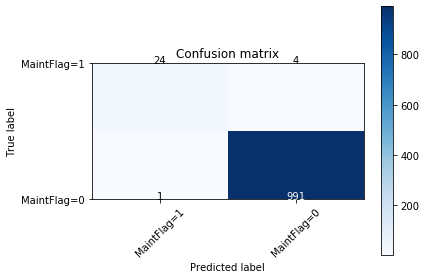

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MaintFlag=1','MaintFlag=0'],normalize= False,  title='Confusion matrix')

In [22]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       992
         1.0       0.96      0.86      0.91        28

    accuracy                           1.00      1020
   macro avg       0.98      0.93      0.95      1020
weighted avg       0.99      1.00      0.99      1020



In [23]:
# Compute cross entropy loss for the ground truth and the predicted probability 
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)


0.09043759724939252

In [24]:
import pickle

#serializing our model to a file called model_logistic_regression.pkl
pickle.dump(LR, open("model_logistic_regression.pkl","wb"))